In [3]:
!wget https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/5y9wdsg2zt-2.zip

--2023-05-28 15:03:52--  https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/5y9wdsg2zt-2.zip
Resolving prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)... 3.5.66.177, 52.92.18.226, 52.92.18.234, ...
Connecting to prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)|3.5.66.177|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 240847944 (230M) [application/octet-stream]
Saving to: ‘5y9wdsg2zt-2.zip’

5y9wdsg2zt-2.zip    100%[===================>] 229.69M  10.9MB/s    in 20s     

2023-05-28 15:04:13 (11.5 MB/s) - ‘5y9wdsg2zt-2.zip’ saved [240847944/240847944]



In [4]:
!unzip 5y9wdsg2zt-2.zip

Archive:  5y9wdsg2zt-2.zip
  inflating: Concrete Crack Images for Classification.rar  


In [6]:
!unrar x '/content/Concrete Crack Images for Classification.rar'


Streaming output truncated to the last 5000 lines.
Extracting  Negative/15002.jpg                                            88%  OK 
Extracting  Negative/15003.jpg                                            88%  OK 
Extracting  Negative/15004.jpg                                            88%  OK 
Extracting  Negative/15005.jpg                                            88%  OK 
Extracting  Negative/15006.jpg                                            88%  OK 
Extracting  Negative/15007.jpg                                            88%  OK 
Extracting  Negative/15008.jpg                                            88%  OK 
Extracting  Negative/15009.jpg                                            88%  OK 
Extracting  Negative/15010.jpg                                            88%  OK 
Extracting  Negative/15011.jpg                                            88%  OK 
Extracting  Negative/15012.jp

In [5]:
!pwd

/content


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import torchvision
import numpy as np
import os
cwd = os.getcwd()
from PIL import Image
import time
import copy
import random
import cv2
import re
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab import drive
 
 
%matplotlib inline

In [ ]:
print(cwd)

/content


## Load the Cracks Data set and Visualize it


In [ ]:
import glob
crack_images = os.listdir(r'/content/Positive/')

# crack_images = glob.glob('/content/Positive/*')
print("Number of Crack Images: ", len(crack_images))

Number of Crack Images:  20000


In [ ]:
no_crack_images = os.listdir(r'/content/Negative/')

print("Number of No Crack Images: ", len(no_crack_images))

Number of No Crack Images:  20000


*****************Random Images with Cracks**************************


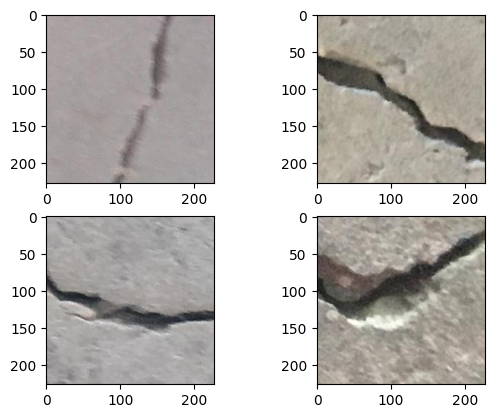

In [ ]:
## Visualize Random images with cracks
random_indices = np.random.randint(0, len(crack_images), size=4)
print("*****************Random Images with Cracks**************************")
random_images = np.array(crack_images)[random_indices.astype(int)]

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(mpimg.imread(os.path.join(cwd, 'Positive/', random_images[0])))
axarr[0,1].imshow(mpimg.imread(os.path.join(cwd, 'Positive/', random_images[1])))
axarr[1,0].imshow(mpimg.imread(os.path.join(cwd, 'Positive/', random_images[2])))
axarr[1,1].imshow(mpimg.imread(os.path.join(cwd, 'Positive/', random_images[3])))

*****************Random Images without Cracks**************************


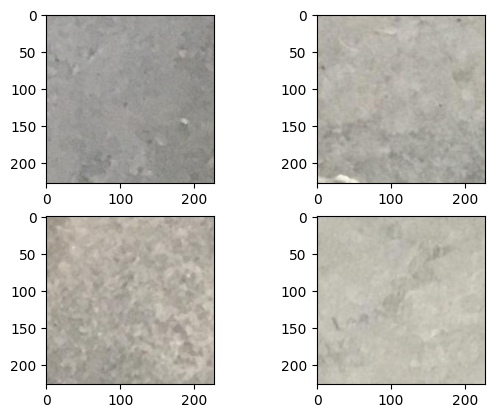

In [ ]:
## Visualize Random images with no cracks
random_indices = np.random.randint(0, len(no_crack_images), size=4)
print("*****************Random Images without Cracks**************************")
random_images = np.array(no_crack_images)[random_indices.astype(int)]

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(mpimg.imread(os.path.join(cwd, 'Negative', random_images[0])))
axarr[0,1].imshow(mpimg.imread(os.path.join(cwd, 'Negative', random_images[1])))
axarr[1,0].imshow(mpimg.imread(os.path.join(cwd, 'Negative', random_images[2])))
axarr[1,1].imshow(mpimg.imread(os.path.join(cwd, 'Negative', random_images[3])))

## Create Train and Val Data sets

### Create training folder

In [ ]:
base_dir = cwd
files = os.listdir(base_dir)
print(base_dir,files)

/content ['.config', '5y9wdsg2zt-2.zip.1', 'Concrete Crack Images for Classification.rar', '5y9wdsg2zt-2.zip', 'val', 'Positive', 'train', '5y9wdsg2zt-2.zip.2', 'Negative', 'sample_data']


In [ ]:
base_dir = r'/content'
files = os.listdir(base_dir)

def create_training_data(folder_name):
    train_dir = f"{base_dir}/train/{folder_name}"
    for f in files:
        search_object = re.search(folder_name, f)
        if search_object:
            shutil.move(f'{base_dir}/{folder_name}', train_dir)

In [ ]:
create_training_data('Positive')
create_training_data('Negative')

### Move images randomly from training to val folders

In [ ]:
os.makedirs('/content/val/Positive')
os.makedirs('/content/val/Negative')

FileExistsError: ignored

In [ ]:
positive_train = base_dir + "/train/Positive"
positive_val = base_dir + "/val/Positive/"
negative_train = base_dir + "/train/Negative"
negative_val = base_dir + "/val/Negative/"

positive_files = os.listdir(positive_train)
negative_files = os.listdir(negative_train)

In [ ]:
print(len(positive_files), len(negative_files))

16011 16090


In [ ]:
for f in positive_files:
    if random.random() > 0.80:
        shutil.move(f'{positive_train}/{f}', positive_val)

In [ ]:
for f in negative_files:
    if random.random() > 0.80:
        shutil.move(f'{negative_train}/{f}', negative_val)

## Pytorch data loader and transforms

### Compute mean and std deviation for the dataset

In [ ]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

In [ ]:
## Define data augmentation and transforms
chosen_transforms = {'train': transforms.Compose([
        transforms.RandomResizedCrop(size=227),
        transforms.RandomRotation(degrees=10),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.15, contrast=0.15),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]), 'val': transforms.Compose([
        transforms.Resize(227),
        transforms.CenterCrop(227),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]),
}

In [ ]:
## Create the data loader
def load_dataset(format, batch_size):
    data_path = os.path.join(r'/content/', format)
    print(format)
    print(data_path)
    dataset = datasets.ImageFolder(
        root=data_path,
        transform= chosen_transforms[format]
    )
    data_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        shuffle=True
    )
    return data_loader, len(dataset), dataset.classes

In [ ]:
## Set code to run on device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# train = os.listdir(r'/content/drive/My Drive/ConcreteCrackImagesforClassification/train/')
# print(train[1])
# train_loader, train_size, class_names = load_dataset(str(train[1]), 8)
# print("Train Data Set size is: ", train_size)
# print("Class Names are: ", class_names)
# inputs, classes = next(iter(train_loader))
# print(inputs.shape, classes.shape)
train_loader, train_size, class_names = load_dataset('train', 8)
print("Train Data Set size is: ", train_size)
print("Class Names are: ", class_names)
inputs, classes = next(iter(train_loader))
print(inputs.shape, classes.shape)

train
/content/train
Train Data Set size is:  45666
Class Names are:  ['Negative', 'Positive']
torch.Size([8, 3, 227, 227]) torch.Size([8])


### Visualize the Augmented Data Set

In [ ]:
# Visualize some images
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([mean_nums])
    std = np.array([std_nums])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated

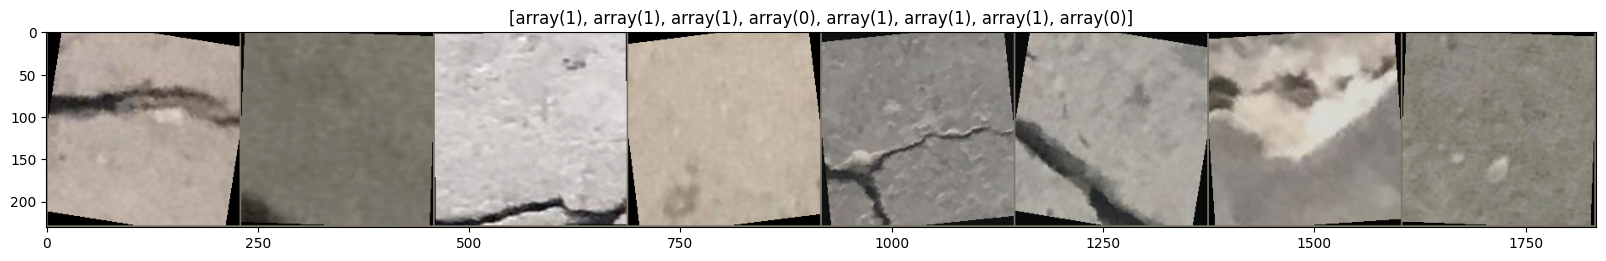

In [ ]:
# Grab some of the training data to visualize
inputs, classes = next(iter(train_loader))
# class_names = chosen_datasets['train'].classes
# Now we construct a grid from batch
out = torchvision.utils.make_grid(inputs)

idx_to_class = {0:'Negative', 1:'Positive'}
plt.figure(figsize=(20,10))
imshow(out, title=[x.data.numpy() for x in classes])

## Set up Pretrained Model

In [ ]:
## Load pretrained model
resnet50 = models.resnet50(pretrained=True)

# Freeze model parameters
for param in resnet50.parameters():
    param.requires_grad = False

## Change the final layer of the resnet model
# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = resnet50.fc.in_features
 
resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, 2)
)

# Convert model to be used on GPU
resnet50 = resnet50.to(device)

from torchsummary import summary
print(summary(resnet50, (3, 227, 227)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 114, 114]           9,408
       BatchNorm2d-2         [-1, 64, 114, 114]             128
              ReLU-3         [-1, 64, 114, 114]               0
         MaxPool2d-4           [-1, 64, 57, 57]               0
            Conv2d-5           [-1, 64, 57, 57]           4,096
       BatchNorm2d-6           [-1, 64, 57, 57]             128
              ReLU-7           [-1, 64, 57, 57]               0
            Conv2d-8           [-1, 64, 57, 57]          36,864
       BatchNorm2d-9           [-1, 64, 57, 57]             128
             ReLU-10           [-1, 64, 57, 57]               0
           Conv2d-11          [-1, 256, 57, 57]          16,384
      BatchNorm2d-12          [-1, 256, 57, 57]             512
           Conv2d-13          [-1, 256, 57, 57]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
# Define Optimizer and Loss Function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters())
# optimizer = optim.SGD(resnet50.fc.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 3 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
# dataloaders = {}
# dataset_sizes = {}
# batch_size = 256
# dataloaders['train'], dataset_sizes['train'], class_names = load_dataset('/content/gdrive/My Drive/ConcreteCrackImagesforClassification/train', batch_size)
# dataloaders['val'], dataset_sizes['val'], _ = load_dataset('/content/gdrive/My Drive/ConcreteCrackImagesforClassification/val', batch_size)
# idx_to_class = {0:'Negative', 1:'Positive'}
dataloaders = {}
dataset_sizes = {}
batch_size = 256
dataloaders['train'], dataset_sizes['train'], class_names = load_dataset('train', batch_size)
dataloaders['val'], dataset_sizes['val'], _ = load_dataset('val', batch_size)
idx_to_class = {0:'Negative', 1:'Positive'}


train
/content/train
val
/content/val


## Start training

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0

            
            print('Iterating through data...')
            c = 0
            for inputs, labels in dataloaders[phase]:
                c += 1
                if c%100==0:
                  print(c)
                # print(c)
                inputs = inputs.to(device)
                labels = labels.to(device)

               
                optimizer.zero_grad()

              
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)

            epoch_loss = current_loss / dataset_sizes[phase]
            epoch_acc = current_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model


In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                plt.show(inputs.cpu().data[j])

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
base_model = train_model(resnet50, criterion, optimizer, exp_lr_scheduler, num_epochs=6)


Epoch 0/5
----------
Iterating through data...
100
train Loss: 0.3310 Acc: 0.8579
Iterating through data...
100
val Loss: 0.4678 Acc: 0.9526

Epoch 1/5
----------
Iterating through data...
100
train Loss: 0.2335 Acc: 0.9242
Iterating through data...
100
val Loss: 0.4356 Acc: 0.9170

Epoch 2/5
----------
Iterating through data...
100
train Loss: 0.2110 Acc: 0.9312
Iterating through data...
100
val Loss: 0.4039 Acc: 0.9420

Epoch 3/5
----------
Iterating through data...
100
train Loss: 0.2080 Acc: 0.9309
Iterating through data...
100
val Loss: 0.3758 Acc: 0.9600

Epoch 4/5
----------
Iterating through data...
100
train Loss: 0.2028 Acc: 0.9335
Iterating through data...
100
val Loss: 0.3854 Acc: 0.9484

Epoch 5/5
----------
Iterating through data...
100
train Loss: 0.2019 Acc: 0.9337
Iterating through data...
100
val Loss: 0.3738 Acc: 0.9561

Training complete in 37m 21s
Best val Acc: 0.959952


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f63831c7400>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f63831c7400>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f63831c7400>    
self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/pyt

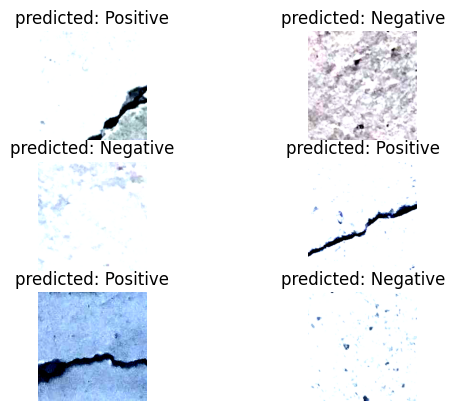

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                plt.imshow(np.transpose(inputs.cpu().data[j].numpy(), (1, 2, 0)))

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return

        model.train(mode=was_training)
visualize_model(base_model)
plt.show()

In [ ]:
model_save_name = 'classifier_crack_detection.pt'
path = F"/content/{model_save_name}" 
torch.save(resnet50.state_dict(), path)

#load model

In [ ]:
model_save_name = 'classifier_crack_detection.pt'
path = F"/content/{model_save_name}"

resnet50.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
resnet50.load_state_dict(torch.load(path))

<All keys matched successfully>

## Inference

In [ ]:
def predict(model, test_image, print_class = False):
     
    transform = chosen_transforms['val']
     
    test_image_tensor = transform(test_image)
 
    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 227, 227).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 227, 227)
     
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(1, dim=1)
        class_name = idx_to_class[topclass.cpu().numpy()[0][0]]
        if print_class:
            print("Output class :  ", class_name)
    return class_name

In [ ]:
def predict_on_crops(input_image, height=227, width=227, save_crops = False):
    im = cv2.imread(input_image)
    imgheight, imgwidth, channels = im.shape
    k=0
    output_image = np.zeros_like(im)
    for i in range(0,imgheight,height):
        for j in range(0,imgwidth,width):
            a = im[i:i+height, j:j+width]
            ## discard image cropss that are not full size
            predicted_class = predict(resnet50,Image.fromarray(a))
            ## save image
            file, ext = os.path.splitext(input_image)
            image_name = file.split('/')[-1]
            folder_name = 'out_' + image_name
            ## Put predicted class on the image
            if predicted_class == 'Positive':
                color = (0,0, 255)
            else:
                color = (0, 255, 0)
            cv2.putText(a, predicted_class, (50,50), cv2.FONT_HERSHEY_SIMPLEX , 0.7, color, 1, cv2.LINE_AA) 
            b = np.zeros_like(a, dtype=np.uint8)
            b[:] = color
            add_img = cv2.addWeighted(a, 0.9, b, 0.1, 0)
            ## Save crops
            if save_crops:
                if not os.path.exists(os.path.join('real_images', folder_name)):
                    os.makedirs(os.path.join('real_images', folder_name))
                filename = os.path.join('real_images', folder_name,'img_{}.png'.format(k))
                cv2.imwrite(filename, add_img)
            output_image[i:i+height, j:j+width,:] = add_img
            k+=1
    ## Save output image
    cv2.imwrite(os.path.join('real_images','predictions', folder_name+ '.jpg'), output_image)
    return output_image

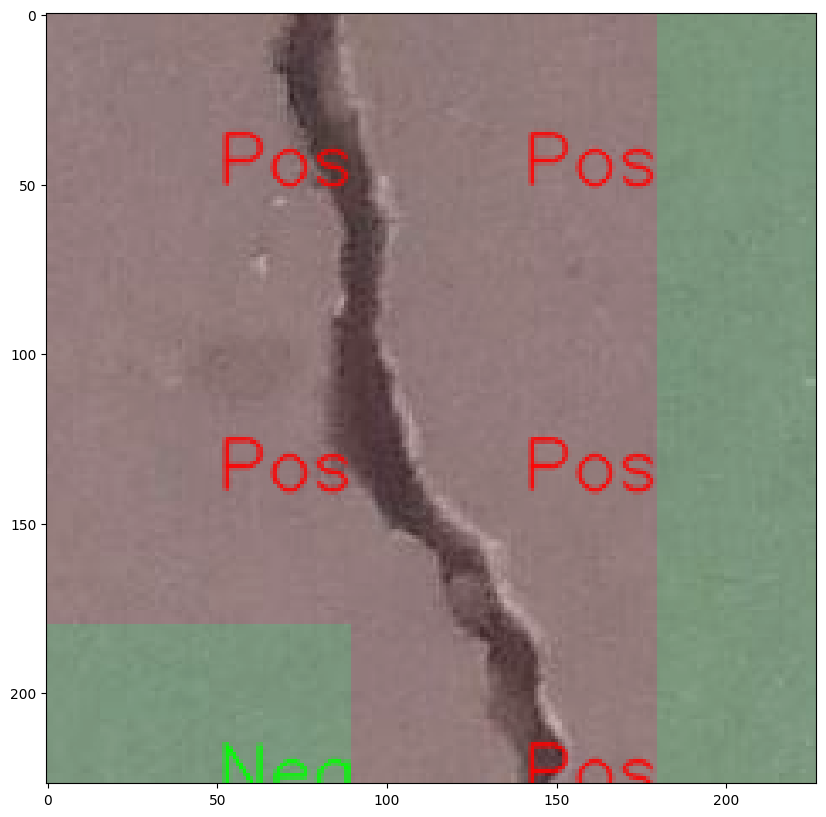

In [ ]:
plt.figure(figsize=(10,10))
output_image = predict_on_crops('/content/val/Positive/00001.jpg', 90, 90)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

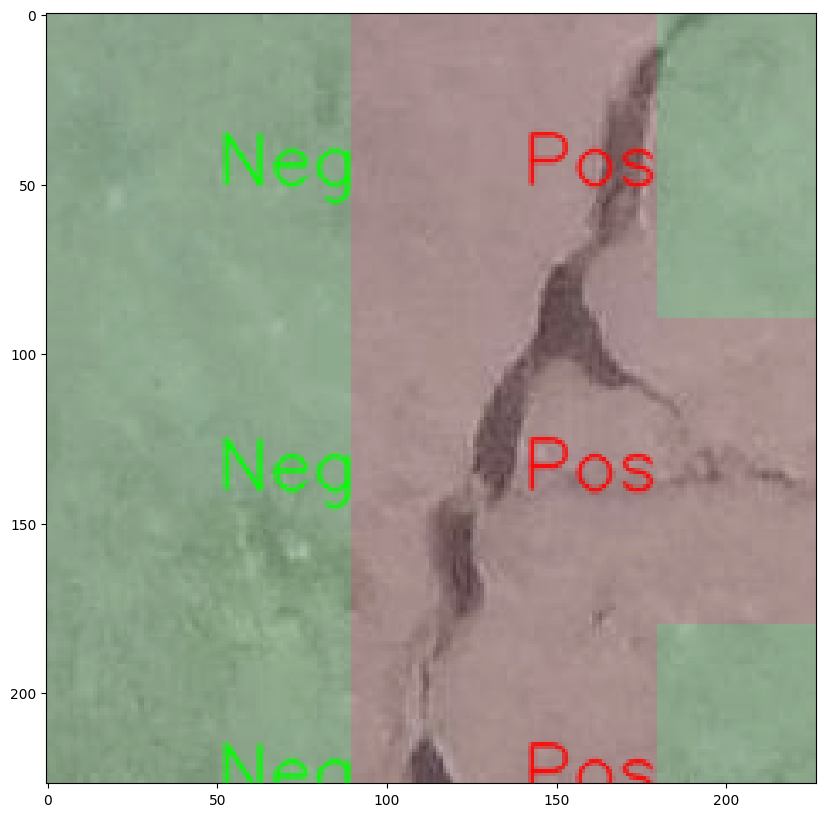

In [ ]:
plt.figure(figsize=(10,10))
output_image = predict_on_crops('/content/val/Positive/00002.jpg', 90, 90)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

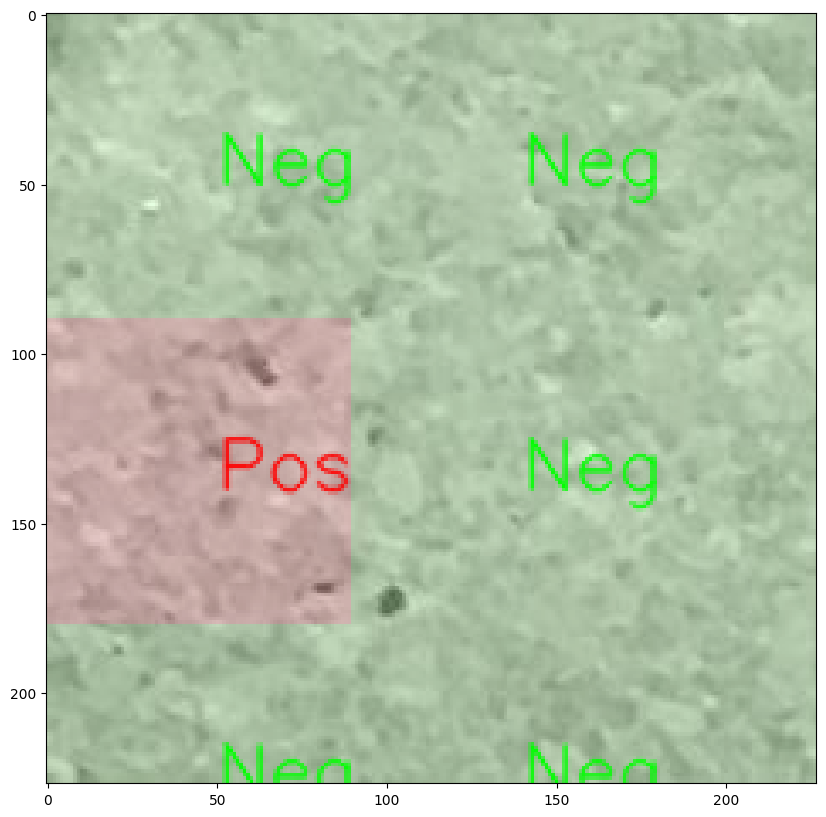

In [ ]:
plt.figure(figsize=(10,10))
output_image = predict_on_crops('/content/val/Negative/00003.jpg', 90, 90)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

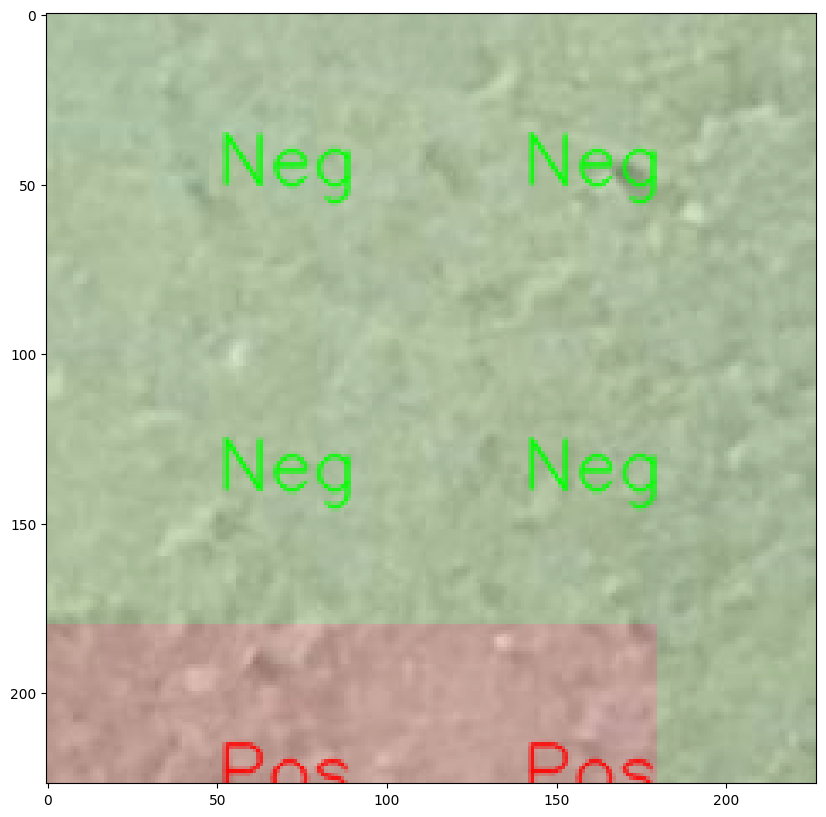

In [ ]:
plt.figure(figsize=(10,10))
output_image = predict_on_crops('/content/val/Negative/Negative/00013.jpg', 90, 90)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

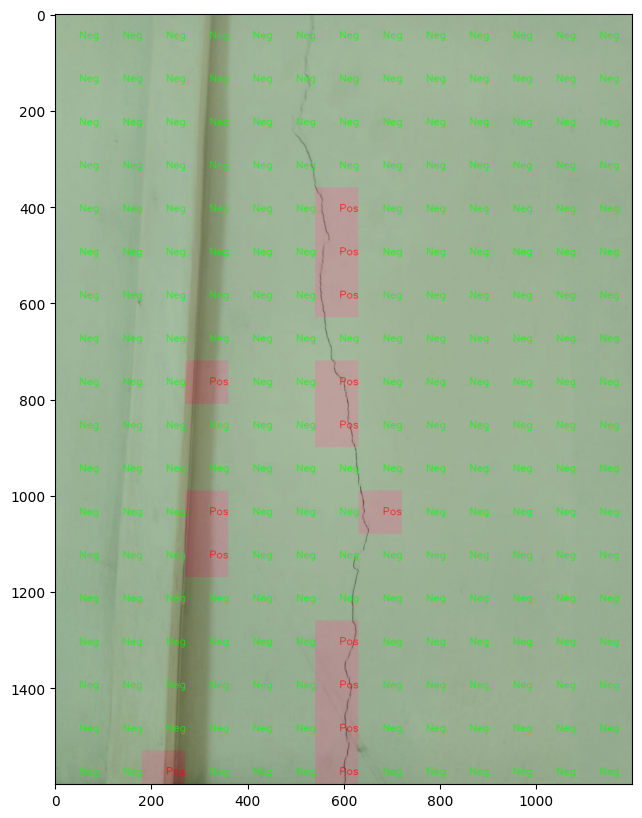

In [ ]:
plt.figure(figsize=(10,10))
output_image = predict_on_crops('/content/t.jpg', 90, 90)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))